In [ ]:
# conda activate RNASeqExampleKG3

In [ ]:
# 
# clustering and pca
#
# n.b.: when restricting the analysis to a set of favorite genes (EnsgID file parameter 6), 
#  use number of genes as parameter 7
#  topExpressed genes heatmap file name will be replaced with geneHeatmap-23genes.pdf 
#  pca and sampleDist plots are also based on these genes only
# 
# recipe stolen from http://www.sthda.com/english/wiki/rna-seq-differential-expression-work-flow-using-deseq2
# 

In [ ]:
# installing/updating libraries:

# install devtools (for installing ComplexHeatmap): conda install r-devtools
# library(devtools)

In [1]:
rm(list=ls())

drawScatterPlots <- F
useRainbowColors <- T

In [2]:
setwd("/data/bcu_projects/MelBrainSys_PostdocProject_Gruetzmann/github/RNA-Seq-analysis-example/")

In [3]:
args = c("clustering", 
         "annotation/GRCh37.p23-EnsgID-GeneSymbol.csv",
         "annotation/annotation.csv", "featCount-noMultiMap.RData", 
         "all-genes.xlsx", "genetypes-remove.txt", "200", "group", "RNA_concentation")

In [4]:
rlogFile <- "rlog.RData"
reUseRlog <- "n"

In [7]:
if (file.exists(rlogFile)) {
  cat(rlogFile,"already exist in current dir., using this one and spare time for rlog operation")
    load(rlogFile)
    reUseRlog="y"
}

In [ ]:
# library("ComplexHeatmap") # -> is broken, can load but doesnt work
# detach("package:ComplexHeatmap", unload=TRUE)

In [9]:
library(pheatmap)
library("ggplot2")
library("Rsubread") # for featureCount

In [13]:
library(xlsx) # broken

Warning message:
“package ‘xlsx’ was built under R version 4.2.1”


ERROR: Error: package or namespace load failed for ‘xlsx’:
 .onLoad failed in loadNamespace() for 'rJava', details:
  call: dyn.load(file, DLLpath = DLLpath, ...)
  error: unable to load shared object '/home/gruetzmko/miniconda3/envs/RNASeqExampleKG3/lib/R/library/rJava/libs/rJava.so':
  libjvm.so: cannot open shared object file: No such file or directory


In [46]:
library("stats") # for PCA
library("DESeq2") # for rlog data
library("scales") # for semi-transparent (alpha) colors
library("circlize") # colorRamp2
library(ggrepel) # plot labels that do not overlap
library(gridExtra) # arrange several plots in one 

In [15]:
padjCutoff <- 0.05
pCutoff <- 0.05

#### check if enough parameters given
and give warning and explanation
when script is run from command line (Rscript), it can be started without paramters to get explanation

In [16]:
if(length(args) <8) {
  cat("ERROR: at least 8 parameters needed: outDir, ensembl gene descr, sample annot,
  featureCountFile, xls outfile for TPMs/counts, file with genetypes to include/exclude or ENSGID, number of genes for clustering (e.g. 50 or 500),
      list of sample annotation column names to add to plots (e.g. Type, DV2000, gender, ..., use several by separating with space char) \n")
  # q("no")
}

#### convert command line parameters to parameters with good names

In [17]:
outDir <- args[1]
outDir <- ifelse(length(grep("\\/$",outDir))==0,paste(outDir,"/",sep=""),outDir)
geneDescrFile <- args[2]
sampleAnnotFile <- args[3]
featureCountFile <- args[4]
rpkmOutfile <- args[5]
genetypeRemoveFile <- args[6]
nbGenesForClustering <- as.numeric(args[7])
annotAttrib <- args[8:length(args)]
nbGeneNameShowCutoff <- 190 # how many genes at most so that names are drawn in plots

#### load gene annotation, clean and inspect:

In [18]:
# gene annotation:
cat("loading gtf gene descr.\n")
annot <- read.csv(gzfile(geneDescrFile),header = T, comment="#",stringsAsFactors = F,sep="\t")
head(annot)
colnames(annot) <- c("ensgID","symbol","description","geneType")
rownames(annot) <- annot$ensgID
annot$description <- gsub("([^\\[]+).*","\\1",annot$description, perl=T)
annot$description <- gsub("(.+) ","\\1",annot$description,perl=T)

loading gtf gene descr.
done


,Ensembl.Gene.ID,Associated.Gene.Name,Description,Gene.type
,<chr>,<chr>,<chr>,<chr>
1,ENSG00000271782,RP5-850O15.4,,lincRNA
2,ENSG00000232753,RP11-347K2.1,,lincRNA
3,ENSG00000225767,RP5-850O15.3,,antisense
4,ENSG00000202140,Y_RNA,Y RNA [Source:RFAM;Acc:RF00019],misc_RNA
5,ENSG00000207194,RNU6-1026P,"RNA, U6 small nuclear 1026, pseudogene [Source:HGNC Symbol;Acc:47989]",snRNA
6,ENSG00000252825,RNU6-1253P,"RNA, U6 small nuclear 1253, pseudogene [Source:HGNC Symbol;Acc:48216]",snRNA


#### load include / exclude list of gene biotypes 

In [19]:
# gene type inclusion/exclusion :
wishedGenetypes <- read.csv(genetypeRemoveFile,header=F,stringsAsFactors = F)
wishedGenetypes <- wishedGenetypes$V1
# is list of Ensg genes?
haveReducedList <- F
if (length(grep("^ENS",wishedGenetypes))>1) {
	geneIDincludeList <- wishedGenetypes
	geneIDincludeList <- geneIDincludeList[grep("ENS",geneIDincludeList)]
	haveReducedList <- T
} else {
  #  is list of gene types:
  if (length(wishedGenetypes)>1) {cat(genetypeRemoveFile," must contain only 1 line with exclude or include list\n");q("no")}
  if(length(grep("include\\s*:|exclude\\s*:",wishedGenetypes,perl=T))!=1) {cat(genetypeRemoveFile,"must contain word include: or exclude:\n"); q("no")}
  if(length(grep("include\\s*:",wishedGenetypes[1],perl=T))==1) {
    geneTypeInclList <- gsub("include\\s*:\\s*(.+)","\\1",wishedGenetypes,perl=T)
    geneTypeInclList <- unlist(strsplit(geneTypeInclList,"\\s"))
    wh <- which(nchar(geneTypeInclList)>0)
    geneTypeInclList <- geneTypeInclList[wh]
    cat("including",geneTypeInclList,"\n")
  }
  if(length(grep("exclude\\s*:",wishedGenetypes[1],perl=T))==1) {
    geneTypeExclList <- gsub("exclude\\s*:\\s*(.+)","\\1",wishedGenetypes,perl=T)
    geneTypeExclList <- unlist(strsplit(geneTypeExclList,"\\s"))
    wh <- which(nchar(geneTypeExclList)>0)
    geneTypeExclList <- geneTypeExclList[wh]
    cat("excluding",geneTypeExclList,"\n")
  }
}

stop1
excluding rRNA Mt_rRNA 
stop2


#### load feature counts and inspect:

In [20]:
load(file = featureCountFile)
counts <- as.matrix(fcountGenes$counts)
rownames(counts) <- gsub("([^\\.]+)\\.?.*","\\1",rownames(counts))
head(counts)
dim(counts)

,R-1090,R-1091,R-1092,R-1093,R-1094,R-1095,R-1096,R-1097,R-1098,R-1099,R-1100,R-1101
ENSG00000223972,0,0,0,0,0,0,0,0,0,0,0,0
ENSG00000227232,14,15,20,13,32,11,12,8,11,16,16,73
ENSG00000243485,0,0,0,0,0,0,0,0,0,0,0,0
ENSG00000237613,0,0,0,0,0,0,0,0,0,0,0,0
ENSG00000268020,0,0,0,0,0,0,0,0,0,0,0,0
ENSG00000240361,0,0,0,0,0,0,0,0,0,0,0,0


[1] 57952    12

#### load sample annotation:

In [21]:
sampleAnnot <- read.csv(file = sampleAnnotFile,sep = "\t", dec=".", stringsAsFactors = F )

head(sampleAnnot)
wh <- which(duplicated(sampleAnnot$ID))
if (length(wh)>0) {
	sampleAnnot <- sampleAnnot[-wh,]
}
sampleAnnot$ID <- as.character(sampleAnnot$ID)
# check if all desired attributes are inside sample annotation:
for (a in annotAttrib) {
  if(! a %in% colnames(sampleAnnot)) {
    cat(a , "is not in sample annotation\n")
    #q("no")
  }
}

,ID,cell_line,group,name,group_full,RNA_concentation,ratio_260_280,ratio_260_230
,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
1,R-1090,UWB1.289,0,R-1090_ctr,UWB1.289_ctr,3804.7,1.96,2.36
2,R-1091,UWB1.289,0,R-1091_ctr,UWB1.289_ctr,3383.5,1.98,2.34
3,R-1092,UWB1.289,CT913,R-1092_CT913,UWB1.289_CT913,2859.8,1.95,2.24
4,R-1093,UWB1.289,CT913,R-1093_CT913,UWB1.289_CT913,3208.5,1.94,2.13
5,R-1094,UWB1.289,CT_M1,R-1094_CT_M1,UWB1.289_CT_M1,2805.7,1.95,2.11
6,R-1095,UWB1.289,CT_M1,R-1095_CT_M1,UWB1.289_CT_M1,2958.1,1.94,2.28


stop3


#### only keep samples in annot where there are counts:

In [22]:
wh <- which(!sampleAnnot$ID %in% colnames(counts)) 
sampleAnnot$ID[wh]
if (length(wh) > 0) {
  cat("removing samples from samples annotation where there are no counts:", paste(sampleAnnot$ID[wh],collapse=", "),"\n")
}
wh <- which(sampleAnnot$ID %in% colnames(counts)) 
length(wh); length(sampleAnnot$ID)
sampleAnnot <- sampleAnnot[wh,]

# only keep sample counts where there is annotation (e.g. when outlier removed from annotation):
wh <- which(!colnames(counts) %in% sampleAnnot$ID )
if (length(wh) >0) {
  cat("removing samples from counts where there is no annotation:",paste(colnames(counts)[wh],collapse=", "),"\n")
  counts <- counts[,-wh]
  totalReads <- totalReads[-wh]
}

character(0)

[1] 12

[1] 12

In [23]:
rownames(sampleAnnot) <- sampleAnnot$ID
dummy <- sapply(annotAttrib,function(x) if (x %in% 
                                   colnames(sampleAnnot)){cat("column",x,"present in sample annot\n")}else{
                                     cat("there is not column ",x,"in sample annotation\n");})
if(!("group" %in% colnames(sampleAnnot) | "type" %in% colnames(sampleAnnot))) {
  cat("need group or type in sample anntation\n")
  # q("no")
}
# change count colnames with annotation names, if there are annot. names:
idNameMap <- sampleAnnot$ID
names(idNameMap) <- idNameMap
if ("name" %in% colnames(sampleAnnot)) {
  if(length(which(duplicated(sampleAnnot$name)))) {
    cat("name column in sample annot. does not have unique names\n")
    # q("no")
  }
  idNameMap <- sampleAnnot$name
  names(idNameMap) <- sampleAnnot$ID
  sampleAnnot$ID <- sampleAnnot$name
  wh <- which(colnames(counts) %in% names(idNameMap))
  length(idNameMap)
  head(counts)
  colnames(counts)[wh] <- idNameMap[colnames(counts)[wh]]
  names(totalReads) <-  colnames(counts)
  rownames(sampleAnnot) <- sampleAnnot$ID
} else {
  if(length(which(duplicated(sampleAnnot$ID)))) {
    cat("ID column in sample annot. does not have unique values\n")
    # q("no")
  }
}

column group present in sample annot
column RNA_concentation present in sample annot


#### all count sample names in annotation ?:

In [24]:
if(!all(colnames(counts) %in% sampleAnnot$ID)) {
  wh <- which(colnames(counts) %in% sampleAnnot$ID)
  cat(paste(length(colnames(counts)[-wh]),"IDs missing in annotation$ID:\n",
            paste(colnames(counts)[-wh],collapse=", ")))#,
              #"\nnot found in sampleAnnot ID:\n",paste(sampleAnnot$ID,collapse=", "),"\n"))
  print("continuing without these ... ")
  counts <- counts[,wh]
  totalReads <- totalReads[wh]
}

#### create TPM from counts

In [25]:
# TPM (transcripts per million mapped reads)
# first normalize by gene length, then by sum of normalized expr per sample
geneLengths <- fcountGenes$annotation[,"Length"]
names(geneLengths) <- fcountGenes$annotation[,"GeneID"]
names(geneLengths) <- gsub("([^\\.]+)\\.?.*","\\1",names(geneLengths))
head(geneLengths)
TPMs <- counts
head(TPMs)
TPMs[,names(totalReads)] <- sapply(names(totalReads),function(x) TPMs[,x]/(geneLengths/10^3) )
head(TPMs[,1:4])
TPMsums <- colSums(TPMs)
TPMs[,names(totalReads)] <- sapply(names(TPMsums),function(x) TPMs[,x]/(TPMsums[x]/10^6))
cat("TPMs:\n")
head(counts[,1:4])
head(TPMs[,1:4])

ENSG00000223972 ENSG00000227232 ENSG00000243485 ENSG00000237613 ENSG00000268020 
           1756            2073            1021            1219             947 
ENSG00000240361 
            940

,R-1090_ctr,R-1091_ctr,R-1092_CT913,R-1093_CT913,R-1094_CT_M1,R-1095_CT_M1,R-1096+BRCA1_ctr,R-1097+BRCA1_ctr,R-1098+BRCA1_CT913,R-1099+BRCA1_CT913,R-1100+BRCA1_CT_M1,R-1101+BRCA1_CT_M1
ENSG00000223972,0,0,0,0,0,0,0,0,0,0,0,0
ENSG00000227232,14,15,20,13,32,11,12,8,11,16,16,73
ENSG00000243485,0,0,0,0,0,0,0,0,0,0,0,0
ENSG00000237613,0,0,0,0,0,0,0,0,0,0,0,0
ENSG00000268020,0,0,0,0,0,0,0,0,0,0,0,0
ENSG00000240361,0,0,0,0,0,0,0,0,0,0,0,0


,R-1090_ctr,R-1091_ctr,R-1092_CT913,R-1093_CT913
ENSG00000223972,0.000000,0.00000,0.000000,0.000000
ENSG00000227232,6.753497,7.23589,9.647853,6.271105
ENSG00000243485,0.000000,0.00000,0.000000,0.000000
ENSG00000237613,0.000000,0.00000,0.000000,0.000000
ENSG00000268020,0.000000,0.00000,0.000000,0.000000
ENSG00000240361,0.000000,0.00000,0.000000,0.000000


TPMs:


,R-1090_ctr,R-1091_ctr,R-1092_CT913,R-1093_CT913
ENSG00000223972,0,0,0,0
ENSG00000227232,14,15,20,13
ENSG00000243485,0,0,0,0
ENSG00000237613,0,0,0,0
ENSG00000268020,0,0,0,0
ENSG00000240361,0,0,0,0


,R-1090_ctr,R-1091_ctr,R-1092_CT913,R-1093_CT913
ENSG00000223972,0.000000,0.000000,0.000000,0.00000
ENSG00000227232,2.546357,2.929086,3.548594,3.32791
ENSG00000243485,0.000000,0.000000,0.000000,0.00000
ENSG00000237613,0.000000,0.000000,0.000000,0.00000
ENSG00000268020,0.000000,0.000000,0.000000,0.00000
ENSG00000240361,0.000000,0.000000,0.000000,0.00000


stop5


In [30]:
head(annot)
geneSymb <- annot$symbol
names(geneSymb) <- annot$ensgID
head(geneSymb)

# save total all reads/TPMs values:
# add annotation:
countsDF <- as.data.frame(counts)
head(countsDF)
countsDF$EnsgID <- rownames(countsDF)
head(annot)
countsDF$symbol <- annot[ rownames(countsDF) ,]$symbol
countsDF$geneType <- annot[ rownames(countsDF) ,]$geneType
countsDF$descr <- annot[ rownames(countsDF) ,]$description
countsDF <- countsDF[,c((ncol(counts)+1):ncol(countsDF),1:ncol(counts))]
print("counts:")
dim(countsDF)
head(countsDF)
which(sampleAnnot$ID %in% colnames(countsDF))

,ensgID,symbol,description,geneType
,<chr>,<chr>,<chr>,<chr>
ENSG00000271782,ENSG00000271782,RP5-850O15.4,,lincRNA
ENSG00000232753,ENSG00000232753,RP11-347K2.1,,lincRNA
ENSG00000225767,ENSG00000225767,RP5-850O15.3,,antisense
ENSG00000202140,ENSG00000202140,Y_RNA,Y RNA,misc_RNA
ENSG00000207194,ENSG00000207194,RNU6-1026P,"RNA, U6 small nuclear 1026, pseudogene",snRNA
ENSG00000252825,ENSG00000252825,RNU6-1253P,"RNA, U6 small nuclear 1253, pseudogene",snRNA


ENSG00000271782 ENSG00000232753 ENSG00000225767 ENSG00000202140 ENSG00000207194 
 "RP5-850O15.4"  "RP11-347K2.1"  "RP5-850O15.3"         "Y_RNA"    "RNU6-1026P" 
ENSG00000252825 
   "RNU6-1253P"

,R-1090_ctr,R-1091_ctr,R-1092_CT913,R-1093_CT913,R-1094_CT_M1,R-1095_CT_M1,R-1096+BRCA1_ctr,R-1097+BRCA1_ctr,R-1098+BRCA1_CT913,R-1099+BRCA1_CT913,R-1100+BRCA1_CT_M1,R-1101+BRCA1_CT_M1
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ENSG00000223972,0,0,0,0,0,0,0,0,0,0,0,0
ENSG00000227232,14,15,20,13,32,11,12,8,11,16,16,73
ENSG00000243485,0,0,0,0,0,0,0,0,0,0,0,0
ENSG00000237613,0,0,0,0,0,0,0,0,0,0,0,0
ENSG00000268020,0,0,0,0,0,0,0,0,0,0,0,0
ENSG00000240361,0,0,0,0,0,0,0,0,0,0,0,0


,ensgID,symbol,description,geneType
,<chr>,<chr>,<chr>,<chr>
ENSG00000271782,ENSG00000271782,RP5-850O15.4,,lincRNA
ENSG00000232753,ENSG00000232753,RP11-347K2.1,,lincRNA
ENSG00000225767,ENSG00000225767,RP5-850O15.3,,antisense
ENSG00000202140,ENSG00000202140,Y_RNA,Y RNA,misc_RNA
ENSG00000207194,ENSG00000207194,RNU6-1026P,"RNA, U6 small nuclear 1026, pseudogene",snRNA
ENSG00000252825,ENSG00000252825,RNU6-1253P,"RNA, U6 small nuclear 1253, pseudogene",snRNA


[1] "counts:"


[1] 57952    16

,EnsgID,symbol,geneType,descr,R-1090_ctr,R-1091_ctr,R-1092_CT913,R-1093_CT913,R-1094_CT_M1,R-1095_CT_M1,R-1096+BRCA1_ctr,R-1097+BRCA1_ctr,R-1098+BRCA1_CT913,R-1099+BRCA1_CT913,R-1100+BRCA1_CT_M1,R-1101+BRCA1_CT_M1
,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ENSG00000223972,ENSG00000223972,DDX11L1,pseudogene,DEAD/H (Asp-Glu-Ala-Asp/His) box helicase 11 like 1,0,0,0,0,0,0,0,0,0,0,0,0
ENSG00000227232,ENSG00000227232,WASH7P,pseudogene,WAS protein family homolog 7 pseudogene,14,15,20,13,32,11,12,8,11,16,16,73
ENSG00000243485,ENSG00000243485,MIR1302-10,lincRNA,microRNA 1302-10,0,0,0,0,0,0,0,0,0,0,0,0
ENSG00000237613,ENSG00000237613,FAM138A,lincRNA,"family with sequence similarity 138, member A",0,0,0,0,0,0,0,0,0,0,0,0
ENSG00000268020,ENSG00000268020,OR4G4P,pseudogene,"olfactory receptor, family 4, subfamily G, member 4 pseudogene",0,0,0,0,0,0,0,0,0,0,0,0
ENSG00000240361,ENSG00000240361,OR4G11P,pseudogene,"olfactory receptor, family 4, subfamily G, member 11 pseudogene",0,0,0,0,0,0,0,0,0,0,0,0


[1]  1  2  3  4  5  6  7  8  9 10 11 12

stop8


In [31]:
head(countsDF[,sampleAnnot$ID])
countsDF$sum <- rowSums(countsDF[,sampleAnnot$ID],na.rm = T)
countsDF$sd <- round(apply(X = countsDF[,sampleAnnot$ID],MARGIN = 1, FUN= function(x) sd(x,na.rm = T)),1)
countsDF <- countsDF[order(countsDF$sum,decreasing = T),]
total <- sum(countsDF$sum)
countsDF$percentOfTotal <- round(countsDF$sum/total*100,2)
head(countsDF$percentOfTotal)
colnames(countsDF)[which(colnames(countsDF)=="percentOfTotal")] <- "% of total"

TPMsDF <- as.data.frame(TPMs)
head(TPMsDF)
TPMsDF$EnsgID <- rownames(TPMsDF)
head(annot)
TPMsDF$symbol <- annot[ rownames(TPMsDF) ,]$symbol
TPMsDF$geneType <- annot[ rownames(TPMsDF) ,]$geneType
TPMsDF$descr <- annot[ rownames(TPMsDF) ,]$description
TPMsDF <- TPMsDF[,c((ncol(TPMs)+1):ncol(TPMsDF),1:ncol(TPMs))]
print("tpms:")
dim(TPMsDF)
head(TPMsDF)
TPMsDF$sum <- rowSums(TPMsDF[,sampleAnnot$ID],na.rm = T)
TPMsDF$sd <- round(apply(X = TPMsDF[,sampleAnnot$ID],MARGIN = 1, FUN= function(x) sd(x,na.rm = T)),1)
TPMsDF <- TPMsDF[order(TPMsDF$sum,decreasing = T),]
total <- sum(TPMsDF$sum)
TPMsDF$percentOfTotal <- round(TPMsDF$sum/total*100,2)
head(TPMsDF$percentOfTotal)
colnames(TPMsDF)[which(colnames(TPMsDF)=="percentOfTotal")] <- "% of total"

totalReadsDF <- data.frame(sample=names(totalReads),non_unique_counts=totalReads)

,R-1090_ctr,R-1091_ctr,R-1092_CT913,R-1093_CT913,R-1094_CT_M1,R-1095_CT_M1,R-1096+BRCA1_ctr,R-1097+BRCA1_ctr,R-1098+BRCA1_CT913,R-1099+BRCA1_CT913,R-1100+BRCA1_CT_M1,R-1101+BRCA1_CT_M1
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ENSG00000223972,0,0,0,0,0,0,0,0,0,0,0,0
ENSG00000227232,14,15,20,13,32,11,12,8,11,16,16,73
ENSG00000243485,0,0,0,0,0,0,0,0,0,0,0,0
ENSG00000237613,0,0,0,0,0,0,0,0,0,0,0,0
ENSG00000268020,0,0,0,0,0,0,0,0,0,0,0,0
ENSG00000240361,0,0,0,0,0,0,0,0,0,0,0,0


[1] 0.96 0.90 0.35 0.32 0.28 0.28

,R-1090_ctr,R-1091_ctr,R-1092_CT913,R-1093_CT913,R-1094_CT_M1,R-1095_CT_M1,R-1096+BRCA1_ctr,R-1097+BRCA1_ctr,R-1098+BRCA1_CT913,R-1099+BRCA1_CT913,R-1100+BRCA1_CT_M1,R-1101+BRCA1_CT_M1
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000223972,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000227232,2.546357,2.929086,3.548594,3.32791,4.164342,2.654741,2.248305,1.767533,2.173754,3.787985,3.437256,7.169821
ENSG00000243485,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000237613,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000268020,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000240361,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


,ensgID,symbol,description,geneType
,<chr>,<chr>,<chr>,<chr>
ENSG00000271782,ENSG00000271782,RP5-850O15.4,,lincRNA
ENSG00000232753,ENSG00000232753,RP11-347K2.1,,lincRNA
ENSG00000225767,ENSG00000225767,RP5-850O15.3,,antisense
ENSG00000202140,ENSG00000202140,Y_RNA,Y RNA,misc_RNA
ENSG00000207194,ENSG00000207194,RNU6-1026P,"RNA, U6 small nuclear 1026, pseudogene",snRNA
ENSG00000252825,ENSG00000252825,RNU6-1253P,"RNA, U6 small nuclear 1253, pseudogene",snRNA


[1] "tpms:"


[1] 57952    16

,EnsgID,symbol,geneType,descr,R-1090_ctr,R-1091_ctr,R-1092_CT913,R-1093_CT913,R-1094_CT_M1,R-1095_CT_M1,R-1096+BRCA1_ctr,R-1097+BRCA1_ctr,R-1098+BRCA1_CT913,R-1099+BRCA1_CT913,R-1100+BRCA1_CT_M1,R-1101+BRCA1_CT_M1
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000223972,ENSG00000223972,DDX11L1,pseudogene,DEAD/H (Asp-Glu-Ala-Asp/His) box helicase 11 like 1,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000227232,ENSG00000227232,WASH7P,pseudogene,WAS protein family homolog 7 pseudogene,2.546357,2.929086,3.548594,3.32791,4.164342,2.654741,2.248305,1.767533,2.173754,3.787985,3.437256,7.169821
ENSG00000243485,ENSG00000243485,MIR1302-10,lincRNA,microRNA 1302-10,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000237613,ENSG00000237613,FAM138A,lincRNA,"family with sequence similarity 138, member A",0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000268020,ENSG00000268020,OR4G4P,pseudogene,"olfactory receptor, family 4, subfamily G, member 4 pseudogene",0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000240361,ENSG00000240361,OR4G11P,pseudogene,"olfactory receptor, family 4, subfamily G, member 11 pseudogene",0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


[1] 2.04 1.88 0.85 0.77 0.56 0.46

stop9


#### regularized logarithmic transformation, or VST:

In [32]:
head(TPMs)
colnames(TPMs) <- as.character(colnames(TPMs))
print("rlog data...")
# TPMsRlog <- round(TPMs)
# must be converted to integer first
TPMs[,names(totalReads)] <- TPMs[,names(totalReads)] + 1
if (reUseRlog!="y") {
  #TPMsRlog <- varianceStabilizingTransformation(round(as.matrix(TPMs[,names(totalReads)]) *10))/3
  TPMsRlog <- rlog(round(as.matrix(TPMs[,names(totalReads)]) *10))/3
  save(TPMsRlog,file = rlogFile)
}
print("done")
head(TPMsRlog)
head(TPMs)
dim(TPMsRlog); dim(TPMs)
head(counts)
all(rownames(TPMs) == rownames(counts))
rownames(TPMsRlog) <- rownames(counts)
head(TPMsRlog)

,R-1090_ctr,R-1091_ctr,R-1092_CT913,R-1093_CT913,R-1094_CT_M1,R-1095_CT_M1,R-1096+BRCA1_ctr,R-1097+BRCA1_ctr,R-1098+BRCA1_CT913,R-1099+BRCA1_CT913,R-1100+BRCA1_CT_M1,R-1101+BRCA1_CT_M1
ENSG00000223972,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000227232,2.546357,2.929086,3.548594,3.32791,4.164342,2.654741,2.248305,1.767533,2.173754,3.787985,3.437256,7.169821
ENSG00000243485,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000237613,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000268020,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000240361,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


[1] "rlog data..."
[1] "done"


,R-1090_ctr,R-1091_ctr,R-1092_CT913,R-1093_CT913,R-1094_CT_M1,R-1095_CT_M1,R-1096+BRCA1_ctr,R-1097+BRCA1_ctr,R-1098+BRCA1_CT913,R-1099+BRCA1_CT913,R-1100+BRCA1_CT_M1,R-1101+BRCA1_CT_M1
ENSG00000223972,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309
ENSG00000227232,1.765705,1.784488,1.810820,1.802271,1.839136,1.775229,1.750889,1.730048,1.750889,1.823249,1.806573,1.939195
ENSG00000243485,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309
ENSG00000237613,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309
ENSG00000268020,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309
ENSG00000240361,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309


,R-1090_ctr,R-1091_ctr,R-1092_CT913,R-1093_CT913,R-1094_CT_M1,R-1095_CT_M1,R-1096+BRCA1_ctr,R-1097+BRCA1_ctr,R-1098+BRCA1_CT913,R-1099+BRCA1_CT913,R-1100+BRCA1_CT_M1,R-1101+BRCA1_CT_M1
ENSG00000223972,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
ENSG00000227232,3.546357,3.929086,4.548594,4.32791,5.164342,3.654741,3.248305,2.767533,3.173754,4.787985,4.437256,8.169821
ENSG00000243485,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
ENSG00000237613,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
ENSG00000268020,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
ENSG00000240361,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


[1] 57952    12

[1] 57952    12

stop10


,R-1090_ctr,R-1091_ctr,R-1092_CT913,R-1093_CT913,R-1094_CT_M1,R-1095_CT_M1,R-1096+BRCA1_ctr,R-1097+BRCA1_ctr,R-1098+BRCA1_CT913,R-1099+BRCA1_CT913,R-1100+BRCA1_CT_M1,R-1101+BRCA1_CT_M1
ENSG00000223972,0,0,0,0,0,0,0,0,0,0,0,0
ENSG00000227232,14,15,20,13,32,11,12,8,11,16,16,73
ENSG00000243485,0,0,0,0,0,0,0,0,0,0,0,0
ENSG00000237613,0,0,0,0,0,0,0,0,0,0,0,0
ENSG00000268020,0,0,0,0,0,0,0,0,0,0,0,0
ENSG00000240361,0,0,0,0,0,0,0,0,0,0,0,0


[1] TRUE

,R-1090_ctr,R-1091_ctr,R-1092_CT913,R-1093_CT913,R-1094_CT_M1,R-1095_CT_M1,R-1096+BRCA1_ctr,R-1097+BRCA1_ctr,R-1098+BRCA1_CT913,R-1099+BRCA1_CT913,R-1100+BRCA1_CT_M1,R-1101+BRCA1_CT_M1
ENSG00000223972,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309
ENSG00000227232,1.765705,1.784488,1.810820,1.802271,1.839136,1.775229,1.750889,1.730048,1.750889,1.823249,1.806573,1.939195
ENSG00000243485,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309
ENSG00000237613,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309
ENSG00000268020,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309
ENSG00000240361,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309


,R-1090_ctr,R-1091_ctr,R-1092_CT913,R-1093_CT913,R-1094_CT_M1,R-1095_CT_M1,R-1096+BRCA1_ctr,R-1097+BRCA1_ctr,R-1098+BRCA1_CT913,R-1099+BRCA1_CT913,R-1100+BRCA1_CT_M1,R-1101+BRCA1_CT_M1
ENSG00000223972,0,0,0,0,0,0,0,0,0,0,0,0
ENSG00000227232,14,15,20,13,32,11,12,8,11,16,16,73
ENSG00000243485,0,0,0,0,0,0,0,0,0,0,0,0
ENSG00000237613,0,0,0,0,0,0,0,0,0,0,0,0
ENSG00000268020,0,0,0,0,0,0,0,0,0,0,0,0
ENSG00000240361,0,0,0,0,0,0,0,0,0,0,0,0


[1] "ENSG00000223972" "ENSG00000227232" "ENSG00000243485" "ENSG00000237613"
[5] "ENSG00000268020" "ENSG00000240361"

stop11


#### make data.frame for exporting

In [33]:
TPMsRlogDF <- as.data.frame(TPMsRlog)
head(TPMsRlogDF)
TPMsRlogDF$EnsgID <- rownames(TPMsRlogDF)
head(annot)
TPMsRlogDF$symbol <- annot[ rownames(TPMsRlogDF) ,]$symbol
TPMsRlogDF$geneType <- annot[ rownames(TPMsRlogDF) ,]$geneType
TPMsRlogDF$descr <- annot[ rownames(TPMsRlogDF) ,]$description
TPMsRlogDF <- TPMsRlogDF[,c((ncol(TPMs)+1):ncol(TPMsRlogDF),1:ncol(TPMs))]
print("tpms:")
dim(TPMsRlogDF)
head(TPMsRlogDF)
if(!all(sampleAnnot$ID %in% colnames(TPMsRlogDF))) {
    cat("not all annot IDs/names are in colnames of TPMsRlogDF\n",
       paste0(setdiff(sampleAnnot$ID, colnames(TPMsRlogDF)),collapse = " "))
}
TPMsRlogDF$sum <- rowSums(TPMsRlogDF[,sampleAnnot$ID],na.rm = T)
TPMsRlogDF$sd <- round(apply(X = TPMsRlogDF[,sampleAnnot$ID],MARGIN = 1, FUN= function(x) sd(x,na.rm = T)),1)
TPMsRlogDF <- TPMsRlogDF[order(TPMsRlogDF$sum,decreasing = T),]
total <- sum(TPMsRlogDF$sum)
TPMsRlogDF$percentOfTotal <- round(TPMsRlogDF$sum/total*100,3)
head(TPMsRlogDF$percentOfTotal)
sum(TPMsRlogDF$percentOfTotal)
colnames(TPMsRlogDF)[which(colnames(TPMsRlogDF)=="percentOfTotal")] <- "% of total"
sum(TPMsRlogDF$"% of total")
head(TPMsRlogDF$"% of total")

# ensgID symbol map
geneSymbols <- annot[ rownames(TPMsRlogDF) ,]$symbol
names(geneSymbols) <- rownames(TPMsRlogDF)
ensgIDs <- names(geneSymb)
names(ensgIDs) <- geneSymb
head(ensgIDs)
head(geneSymbols)

,R-1090_ctr,R-1091_ctr,R-1092_CT913,R-1093_CT913,R-1094_CT_M1,R-1095_CT_M1,R-1096+BRCA1_ctr,R-1097+BRCA1_ctr,R-1098+BRCA1_CT913,R-1099+BRCA1_CT913,R-1100+BRCA1_CT_M1,R-1101+BRCA1_CT_M1
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000223972,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309
ENSG00000227232,1.765705,1.784488,1.810820,1.802271,1.839136,1.775229,1.750889,1.730048,1.750889,1.823249,1.806573,1.939195
ENSG00000243485,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309
ENSG00000237613,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309
ENSG00000268020,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309
ENSG00000240361,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309


,ensgID,symbol,description,geneType
,<chr>,<chr>,<chr>,<chr>
ENSG00000271782,ENSG00000271782,RP5-850O15.4,,lincRNA
ENSG00000232753,ENSG00000232753,RP11-347K2.1,,lincRNA
ENSG00000225767,ENSG00000225767,RP5-850O15.3,,antisense
ENSG00000202140,ENSG00000202140,Y_RNA,Y RNA,misc_RNA
ENSG00000207194,ENSG00000207194,RNU6-1026P,"RNA, U6 small nuclear 1026, pseudogene",snRNA
ENSG00000252825,ENSG00000252825,RNU6-1253P,"RNA, U6 small nuclear 1253, pseudogene",snRNA


[1] "tpms:"


[1] 57952    16

,EnsgID,symbol,geneType,descr,R-1090_ctr,R-1091_ctr,R-1092_CT913,R-1093_CT913,R-1094_CT_M1,R-1095_CT_M1,R-1096+BRCA1_ctr,R-1097+BRCA1_ctr,R-1098+BRCA1_CT913,R-1099+BRCA1_CT913,R-1100+BRCA1_CT_M1,R-1101+BRCA1_CT_M1
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000223972,ENSG00000223972,DDX11L1,pseudogene,DEAD/H (Asp-Glu-Ala-Asp/His) box helicase 11 like 1,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309
ENSG00000227232,ENSG00000227232,WASH7P,pseudogene,WAS protein family homolog 7 pseudogene,1.765705,1.784488,1.810820,1.802271,1.839136,1.775229,1.750889,1.730048,1.750889,1.823249,1.806573,1.939195
ENSG00000243485,ENSG00000243485,MIR1302-10,lincRNA,microRNA 1302-10,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309
ENSG00000237613,ENSG00000237613,FAM138A,lincRNA,"family with sequence similarity 138, member A",1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309
ENSG00000268020,ENSG00000268020,OR4G4P,pseudogene,"olfactory receptor, family 4, subfamily G, member 4 pseudogene",1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309
ENSG00000240361,ENSG00000240361,OR4G11P,pseudogene,"olfactory receptor, family 4, subfamily G, member 11 pseudogene",1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309


[1] 0.007 0.007 0.006 0.006 0.006 0.006

[1] 90.445

[1] 90.445

[1] 0.007 0.007 0.006 0.006 0.006 0.006

RP5-850O15.4      RP11-347K2.1      RP5-850O15.3             Y_RNA 
"ENSG00000271782" "ENSG00000232753" "ENSG00000225767" "ENSG00000202140" 
       RNU6-1026P        RNU6-1253P 
"ENSG00000207194" "ENSG00000252825"

ENSG00000265039 ENSG00000263900 ENSG00000266077 ENSG00000034510 ENSG00000156508 
   "AC107016.2"    "AC006483.1"    "AC139149.1"        "TMSB10"        "EEF1A1" 
ENSG00000087086 
          "FTL"

stop12


In [34]:
if (rpkmOutfile!="n") {
    
  # order samples by group then sample name:
  head(sampleAnnot)
  if(length(which(colnames(sampleAnnot)=="group"))==1) {
    groupVar <- "group"
  } else {
    if(length(which(colnames(sampleAnnot)=="type"))==1) {
      groupVar <- "type"
    } else { # take any first var. that matches group/type
      groupVar <- grep("group|type",colnames(sampleAnnot), value=T)[1]
    }
  }
  cat("groupvar",groupVar,"\n")
  sampleIDsGroupOrder <- order(sampleAnnot[names(totalReads),groupVar], sampleAnnot[names(totalReads),"ID"])
  sampleIDsGroupOrdered <- names(totalReads)[sampleIDsGroupOrder]
  totalReadsDF <- totalReadsDF[sampleIDsGroupOrder,]
  otherColumnNames <- setdiff(colnames(countsDF),sampleIDsGroupOrdered)
  head(countsDF)
  groupAnnotationDF <- as.data.frame(t(c(rep("",length(otherColumnNames)),sampleAnnot[sampleIDsGroupOrdered,groupVar]) ))
  colnames(groupAnnotationDF) <- c(otherColumnNames,sampleIDsGroupOrdered)

  rpkmOutfileBase <- gsub("\\.xlsx?","",rpkmOutfile)

  write.table(x = cbind(group=sampleAnnot[sampleIDsGroupOrdered,groupVar],totalReadsDF),
              file= paste0(outDir,rpkmOutfileBase,"-totalReads.csv"), quote = F,sep = "\t",row.names = F)
  
  write.table(x = groupAnnotationDF,file = paste0(outDir,rpkmOutfileBase,"-counts.csv"),
              quote = F,sep = "\t",row.names = F, col.names=F)
  write.table(x = countsDF[,c(otherColumnNames,sampleIDsGroupOrdered)],
              file = paste0(outDir,rpkmOutfileBase,"-counts.csv"),quote = F,sep = "\t",row.names = F,append = T)

  write.table(x = groupAnnotationDF,file = paste0(outDir,rpkmOutfileBase,"-TPMs.csv"),
              quote = F,sep = "\t",row.names = F, col.names=F)
  write.table(x = TPMsDF[,c(otherColumnNames,sampleIDsGroupOrdered)],
              file = paste0(outDir,rpkmOutfileBase,"-TPMs.csv"),quote = F,sep = "\t",row.names = F,append = T)

  write.table(x = groupAnnotationDF,file = paste0(outDir,rpkmOutfileBase,"-rlogTPMs.csv"),
              quote = F,sep = "\t",row.names = F, col.names=F)
  write.table(x = TPMsRlogDF[,c(otherColumnNames,sampleIDsGroupOrdered)],
              file = paste0(outDir,rpkmOutfileBase,"-rlogTPMs.csv"),quote = F,sep = "\t",row.names = F,append = T)
}

groupvar group 


Warning message in write.table(x = countsDF[, c(otherColumnNames, sampleIDsGroupOrdered)], :
“appending column names to file”
Warning message in write.table(x = TPMsDF[, c(otherColumnNames, sampleIDsGroupOrdered)], :
“appending column names to file”
Warning message in write.table(x = TPMsRlogDF[, c(otherColumnNames, sampleIDsGroupOrdered)], :
“appending column names to file”


In [35]:
head(TPMsRlog)
head(TPMsRlogDF)
dim(TPMsRlog); dim(TPMsRlogDF)

# TPMsRlog: remove genes of biotype or reduce to desired genes:

# include gene types:
if (exists("geneTypeInclList")) {
  geneIds2incl <- annot$ensgID[which(annot$geneType %in% geneTypeInclList)]
  wh2incl <- which(rownames(TPMsRlog) %in% geneIds2incl)
  print(paste("including",length(intersect(rownames(TPMsRlog),geneIds2incl)),"genes from TPM"))
  if(length(wh2incl)>0) {
    print(paste(length(intersect(rownames(TPMsRlog),geneIds2incl)),"genes to keep (",paste(geneTypeInclList,collapse=", "),")"))
    TPMsRlog <- TPMsRlog[wh2incl,]
  }
}
# exclude gene types:
if (exists("geneTypeExclList")) {
  geneIds2remove <- annot$ensgID[which(annot$geneType %in% geneTypeExclList)]
  wh2rm <- which(rownames(TPMsRlog) %in% geneIds2remove)
  length(rownames(TPMsRlog))
  print(paste("removing",length(intersect(rownames(TPMsRlog),geneIds2remove)),"genes from TPKM"))
  if(length(wh2rm)>0) {
    print(paste(length(intersect(rownames(TPMsRlog),geneIds2remove)),"genes to remove (",paste(geneTypeExclList,collapse=", "),")"))
    TPMsRlog <- TPMsRlog[-wh2rm,]
  }
}

# include gene ids:
if (exists("geneIDincludeList")) {
  wh2incl <- which(rownames(TPMsRlog) %in% geneIDincludeList)
  print(paste("including",length(intersect(rownames(TPMsRlog),geneIDincludeList)),"genes from TPKM"))
  if(length(wh2incl)>0) {
    print(paste(length(intersect(rownames(TPMsRlog),geneIDincludeList)),
                "genes to keep (",paste(geneIDincludeList,collapse=", "),")"))
    TPMsRlog <- TPMsRlog[wh2incl,]
  }
}
head(annot)
dim(TPMsRlog)

,R-1090_ctr,R-1091_ctr,R-1092_CT913,R-1093_CT913,R-1094_CT_M1,R-1095_CT_M1,R-1096+BRCA1_ctr,R-1097+BRCA1_ctr,R-1098+BRCA1_CT913,R-1099+BRCA1_CT913,R-1100+BRCA1_CT_M1,R-1101+BRCA1_CT_M1
ENSG00000223972,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309
ENSG00000227232,1.765705,1.784488,1.810820,1.802271,1.839136,1.775229,1.750889,1.730048,1.750889,1.823249,1.806573,1.939195
ENSG00000243485,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309
ENSG00000237613,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309
ENSG00000268020,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309
ENSG00000240361,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309


,EnsgID,symbol,geneType,descr,R-1090_ctr,R-1091_ctr,R-1092_CT913,R-1093_CT913,R-1094_CT_M1,R-1095_CT_M1,R-1096+BRCA1_ctr,R-1097+BRCA1_ctr,R-1098+BRCA1_CT913,R-1099+BRCA1_CT913,R-1100+BRCA1_CT_M1,R-1101+BRCA1_CT_M1,sum,sd,% of total
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000265039,ENSG00000265039,AC107016.2,miRNA,,5.893427,5.914469,5.755807,5.779008,5.876275,5.834468,5.896498,5.896724,5.802458,5.840672,5.933186,5.981638,70.40463,0.1,0.007
ENSG00000263900,ENSG00000263900,AC006483.1,miRNA,,5.823309,5.857941,5.836990,5.826830,5.894214,5.864670,5.764503,5.746105,5.730841,5.788661,5.863535,5.940495,69.93809,0.1,0.007
ENSG00000266077,ENSG00000266077,AC139149.1,miRNA,,5.365386,5.392200,5.397819,5.423690,5.499015,5.421607,5.360340,5.341289,5.283596,5.391781,5.554300,5.669095,65.10012,0.1,0.006
ENSG00000034510,ENSG00000034510,TMSB10,protein_coding,thymosin beta 10,5.430352,5.436941,5.384324,5.370859,5.423469,5.423799,5.388026,5.404501,5.364903,5.372774,5.426279,5.454274,64.88050,0.0,0.006
ENSG00000156508,ENSG00000156508,EEF1A1,protein_coding,eukaryotic translation elongation factor 1 alpha 1,5.213395,5.204600,5.185496,5.170613,5.231893,5.224838,5.317051,5.316640,5.292341,5.274078,5.295308,5.287508,63.01376,0.1,0.006
ENSG00000087086,ENSG00000087086,FTL,protein_coding,"ferritin, light polypeptide",5.053152,5.058678,5.210211,5.204617,5.159103,5.152984,5.068745,5.075220,5.187473,5.228274,5.191565,5.229670,61.81969,0.1,0.006


[1] 57952    12

[1] 57952    19

[1] "removing 528 genes from TPKM"
[1] "528 genes to remove ( rRNA, Mt_rRNA )"


,ensgID,symbol,description,geneType
,<chr>,<chr>,<chr>,<chr>
ENSG00000271782,ENSG00000271782,RP5-850O15.4,,lincRNA
ENSG00000232753,ENSG00000232753,RP11-347K2.1,,lincRNA
ENSG00000225767,ENSG00000225767,RP5-850O15.3,,antisense
ENSG00000202140,ENSG00000202140,Y_RNA,Y RNA,misc_RNA
ENSG00000207194,ENSG00000207194,RNU6-1026P,"RNA, U6 small nuclear 1026, pseudogene",snRNA
ENSG00000252825,ENSG00000252825,RNU6-1253P,"RNA, U6 small nuclear 1253, pseudogene",snRNA


[1] 57424    12

#### replace ENSG with symbols, where there is a symbol, otherwise keep Ensg

In [36]:
wh <- which(!is.na(annot[rownames(TPMsRlog),"symbol"]))
if( length(wh) > 0) {
    rownames(TPMsRlog)[wh] <- annot[rownames(TPMsRlog)[wh],"symbol"]
}
head(annot)
head(TPMsRlog) 
dim(TPMsRlog) 

,ensgID,symbol,description,geneType
,<chr>,<chr>,<chr>,<chr>
ENSG00000271782,ENSG00000271782,RP5-850O15.4,,lincRNA
ENSG00000232753,ENSG00000232753,RP11-347K2.1,,lincRNA
ENSG00000225767,ENSG00000225767,RP5-850O15.3,,antisense
ENSG00000202140,ENSG00000202140,Y_RNA,Y RNA,misc_RNA
ENSG00000207194,ENSG00000207194,RNU6-1026P,"RNA, U6 small nuclear 1026, pseudogene",snRNA
ENSG00000252825,ENSG00000252825,RNU6-1253P,"RNA, U6 small nuclear 1253, pseudogene",snRNA


,R-1090_ctr,R-1091_ctr,R-1092_CT913,R-1093_CT913,R-1094_CT_M1,R-1095_CT_M1,R-1096+BRCA1_ctr,R-1097+BRCA1_ctr,R-1098+BRCA1_CT913,R-1099+BRCA1_CT913,R-1100+BRCA1_CT_M1,R-1101+BRCA1_CT_M1
DDX11L1,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309
WASH7P,1.765705,1.784488,1.810820,1.802271,1.839136,1.775229,1.750889,1.730048,1.750889,1.823249,1.806573,1.939195
MIR1302-10,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309
FAM138A,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309
OR4G4P,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309
OR4G11P,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309


[1] 57424    12

#### define colors for plot

In [38]:
# reduce color annotation to actual samples
# very important, or Heatmap will produce wrong annotation:
sampleAnnotForPlot <- sampleAnnot[colnames(TPMsRlog),annotAttrib, drop=F] 
whCol <- grep("color",colnames(sampleAnnot),value=T)
sampleAnnotForPlotColor <- sampleAnnot[colnames(TPMsRlog),whCol, drop=F] 
# produce annotation color discrete/continuous:
# define color ramps for diff variables:
myColrRamps <- matrix(data = c("#66ff99","#009999","#000099",
                               "blue4","azure","brown1",
                               "#ffd000","#669900","#006600",
                               "#ff99ff","#6666ff","#000099",
                               "#f1e0c5","#71816d","#342a21"),ncol = 3, byrow = T)

In [39]:
hues <- 0:8/8
usedHueStart <- 1

annotColor <- list()
i<-1
useRamp <- 2

for(i in 1:ncol(sampleAnnotForPlot)) {
  colorName <- paste0(colnames(sampleAnnotForPlot)[i],"_color")
  if (is.numeric(sampleAnnotForPlot[,i])) {    # color ramp  when continuous variable
    cat(colorName," is numeric\n")
    breaks <- quantile(sampleAnnotForPlot[,i],c(0,0.5,1), na.rm = T)
    names(breaks) <- NULL
    annotColor <- c(annotColor, list(colorRamp2(breaks = breaks,myColrRamps[useRamp,])))
    cat("color ramp over: ",myColrRamps[useRamp,],"to breaks",breaks,"\n")
    useRamp <- ifelse(useRamp==nrow(myColrRamps),1,useRamp+1)
  } else {     # discrete variable -> fixed colors
    cat(colorName,"is discrete\n")
    if (colorName %in% colnames(sampleAnnotForPlotColor)) { # predefined color?
      cat("predefined colors:\n ")
      cat(unique(sampleAnnotForPlotColor[,colorName]),"\n")
      if("" %in% unique(sampleAnnotForPlotColor[,colorName])) {
        cat("empty values \"\" not allowed in predefined colors, quit\n")
      }
      annotColor <- c(annotColor,list(unique(sampleAnnotForPlotColor[,colorName])))
      names(annotColor[[i]]) <- unique(sampleAnnotForPlot[,i])
    } else { # discrete palette from pre-defined color ramps:

      usedHueStart <- (usedHueStart+1) %% length(hues) + 1
      # the more colors we need, the further away
      usedHueEnd <- (usedHueStart + floor(length(unique(sampleAnnotForPlot[,i])))) %% length(hues) + 1
      annotColor <- c(annotColor,list(
        rainbow(s=0.7,v=0.85,n = length(unique(sampleAnnotForPlot[,i])),start=hues[usedHueStart], end=hues[usedHueEnd])
        ))
      useRamp <- ifelse(useRamp==nrow(myColrRamps),1,useRamp+1)
      cat("used",useRamp,"\n")
      names(annotColor[[i]]) <- unique(sampleAnnotForPlot[,i])
    }
    # sort by annot attrib name:
    annotColor[[i]] <- annotColor[[i]][order(names(annotColor[[i]]))]
  }
}

names(annotColor) <- colnames(sampleAnnotForPlot)

group_color is discrete
used 3 
RNA_concentation_color  is numeric
color ramp over:  #ffd000 #669900 #006600 to breaks 1035.5 2203.65 3804.7 


In [40]:
print("PCA...")
# PCA rlog RPKM:
head(TPMsRlog)
dim(TPMsRlog)
head(t(TPMsRlog)[,1:2])
pc <- prcomp(t(TPMsRlog)) # samples must be rows of the data
names(pc)
dim(pc$x)
length(pc$x[,1])
pc$x[1:4,1]
head(pc$x)
pcs_plot <- as.data.frame(pc$x)
pcs_plot[,annotAttrib] <- sampleAnnotForPlot[rownames(pcs_plot),annotAttrib]
pc3exists <- ifelse("PC3" %in% colnames(pcs_plot),T,F) 
for (i in 1:length(annotAttrib)) {
  colnames(pcs_plot)[which(colnames(pcs_plot)==annotAttrib[i])] <- as.character(paste0("attrib",i))
}
pcs_plot[,"sampleID"] <- rownames(pcs_plot)

dim(pcs_plot)
head(pcs_plot)
pcaOutFile <- paste0("pca-",paste(annotAttrib[1:2],collapse="-"),".pdf")
cat("writing",paste(outDir,pcaOutFile,sep=""),"\n")

maxNameLength <- max(nchar(pcs_plot[,"sampleID"]))

[1] "PCA..."


,R-1090_ctr,R-1091_ctr,R-1092_CT913,R-1093_CT913,R-1094_CT_M1,R-1095_CT_M1,R-1096+BRCA1_ctr,R-1097+BRCA1_ctr,R-1098+BRCA1_CT913,R-1099+BRCA1_CT913,R-1100+BRCA1_CT_M1,R-1101+BRCA1_CT_M1
DDX11L1,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309
WASH7P,1.765705,1.784488,1.810820,1.802271,1.839136,1.775229,1.750889,1.730048,1.750889,1.823249,1.806573,1.939195
MIR1302-10,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309
FAM138A,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309
OR4G4P,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309
OR4G11P,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309


[1] 57424    12

,DDX11L1,WASH7P
R-1090_ctr,1.107309,1.765705
R-1091_ctr,1.107309,1.784488
R-1092_CT913,1.107309,1.810820
R-1093_CT913,1.107309,1.802271
R-1094_CT_M1,1.107309,1.839136
R-1095_CT_M1,1.107309,1.775229


[1] "sdev"     "rotation" "center"   "scale"    "x"

[1] 12 12

[1] 12

R-1090_ctr   R-1091_ctr R-1092_CT913 R-1093_CT913 
   -3.166426    -3.173285    -7.670965    -8.037341

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12
R-1090_ctr,-3.166426,5.077186,-4.9837252,1.394431,-3.371972,0.2980575,0.22858383,1.6205188,4.59912024,-0.18781355,0.7480870,5.117900e-14
R-1091_ctr,-3.173285,5.366006,-4.2847138,1.780674,-2.970432,-1.7613725,-1.77630958,-1.3159196,-4.42166610,0.33673954,0.4335788,3.074293e-14
R-1092_CT913,-7.670965,-5.055368,0.7376444,1.766700,1.000931,-3.0941277,5.10644600,-1.1512718,-0.02030696,0.13314631,0.5643038,1.508255e-14
R-1093_CT913,-8.037341,-4.971976,2.1144175,4.528782,2.566587,2.9128913,-3.31158918,0.3940284,0.19002253,0.06958912,0.3100122,1.409447e-14
R-1094_CT_M1,-5.619095,4.442329,1.5866079,-2.606908,1.414163,-0.7094265,0.01562223,2.6233913,-0.53580206,-0.95621201,-4.5536754,2.779786e-14
R-1095_CT_M1,-5.865990,4.054418,1.0822180,-5.763131,1.334886,2.5565747,0.07900100,-2.4610814,0.17178866,0.46481212,2.4180553,2.568507e-14


[1] 12 15

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,attrib1,attrib2,sampleID
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>
R-1090_ctr,-3.166426,5.077186,-4.9837252,1.394431,-3.371972,0.2980575,0.22858383,1.6205188,4.59912024,-0.18781355,0.7480870,5.117900e-14,0,3804.7,R-1090_ctr
R-1091_ctr,-3.173285,5.366006,-4.2847138,1.780674,-2.970432,-1.7613725,-1.77630958,-1.3159196,-4.42166610,0.33673954,0.4335788,3.074293e-14,0,3383.5,R-1091_ctr
R-1092_CT913,-7.670965,-5.055368,0.7376444,1.766700,1.000931,-3.0941277,5.10644600,-1.1512718,-0.02030696,0.13314631,0.5643038,1.508255e-14,CT913,2859.8,R-1092_CT913
R-1093_CT913,-8.037341,-4.971976,2.1144175,4.528782,2.566587,2.9128913,-3.31158918,0.3940284,0.19002253,0.06958912,0.3100122,1.409447e-14,CT913,3208.5,R-1093_CT913
R-1094_CT_M1,-5.619095,4.442329,1.5866079,-2.606908,1.414163,-0.7094265,0.01562223,2.6233913,-0.53580206,-0.95621201,-4.5536754,2.779786e-14,CT_M1,2805.7,R-1094_CT_M1
R-1095_CT_M1,-5.865990,4.054418,1.0822180,-5.763131,1.334886,2.5565747,0.07900100,-2.4610814,0.17178866,0.46481212,2.4180553,2.568507e-14,CT_M1,2958.1,R-1095_CT_M1


writing clustering/pca-group-RNA_concentation.pdf 


In [47]:
pdf(width = 5+(round(maxNameLength/27)),height = 4,paste(outDir,pcaOutFile,sep=""))

# depending on how many attributes shall be annotated:
# 1 -> point fill color
# 2 -> point fill color and shape
# 3 -> point fill, shape, border color, todo ... 

# 
#  todo:
# - selected continuous scale of pca still don't match those of heatmaps?!
#  - check if pre-defined color scales (in annotation.csv) still work

if (length(annotAttrib)==1) {
  p1 <- ggplot(data = pcs_plot, aes(x = PC1, y = PC2,fill=attrib1)) + 
    geom_point(shape=21, size=2.5) + 
    labs(title=expression("PCA of regularized "~log[2]~"(TPMs)")) +
    geom_text(aes(label=sampleID),hjust=-0.1, vjust=0,size = 1.4, color="#555555")+ 
    scale_x_continuous(limits = c(min(pcs_plot$PC1), max(pcs_plot$PC1)*1.2)) + 
    labs(fill=annotAttrib[1]) 
  
  if(pc3exists) {
    p2 <- ggplot(data = pcs_plot, aes(x = PC2, y = PC3,fill=attrib1)) + 
      geom_point(shape=21, size=2.5) + 
      labs(title=expression("PCA of regularized "~log[2]~"(TPMs)")) +
      geom_text(aes(label=sampleID),hjust=-0.1, vjust=0,size = 1.4, color="#555555")+ 
      scale_x_continuous(limits = c(min(pcs_plot$PC2), max(pcs_plot$PC2)*1.2)) + 
      labs(fill=annotAttrib[1]) 
  }
  if (is.numeric(sampleAnnotForPlot[,1])) { # continuous scale:
    p1 <- p1 + scale_fill_gradient2(low = myColrRamps[1,1],mid = myColrRamps[1,2],high = myColrRamps[1,3], 
                                    midpoint = mean(pcs_plot[,"attrib1"]))
    if(pc3exists) {
      p2 <- p2 + scale_fill_gradient2(low = myColrRamps[1,1],mid = myColrRamps[1,2],high = myColrRamps[1,3], 
                                    midpoint = mean(pcs_plot[,"attrib1"]))
    }
  } else { # manual scale:
    p1 <- p1 + scale_fill_manual(values=annotColor[[1]])
    if(pc3exists) {
      p2 <- p2 + scale_fill_manual(values=annotColor[[1]])
    }
    scale_fill_manual(name=annotAttrib[1],values=annotColor[[1]])
  }
  
  grid.arrange(p1)
  if(pc3exists) {  grid.arrange(p2)  }
}


# todo: when first attrib as shape, second can be continuous
#  -> add continuous scale just as in case where attrib 1 is not shape
# todo2: + geom_text() + labs() + ...   etc. only once at end, not in each case

if (length(annotAttrib)>=2) {
  
  # first attrib less than 6 instances? -> plot it as shape
  if(!is.numeric(sampleAnnotForPlot[,1]) & length(unique(pcs_plot$attrib1))<6) {
   p1 <- ggplot(data = pcs_plot, aes(x = PC1, y = PC2,shape=attrib1,fill=attrib2, color=attrib2)) + 
      geom_point( size=2.5,alpha=0.9) + 
      labs(title=expression("PCA of regularized "~log[2]~"(TPMs)"),
           shape=annotAttrib[1], color=annotAttrib[2])  + guides(fill=F)  +
      #geom_text(aes(label=sampleID),hjust=-0.1, vjust=0,size = 1.4, color="#555555") + 
      #geom_text_repel(aes(label=sampleID),size = 1.4, color="#555555") + 
      geom_text_repel(aes(label=sampleID),size = 1.0, color="#555555") + 
      scale_x_continuous(limits = c(min(pcs_plot$PC1), max(pcs_plot$PC1)*1.5)) +
      scale_shape_manual(values=unique(as.numeric(as.factor(pcs_plot$attrib1)))+20)

   if(pc3exists) {
     p2 <- ggplot(data = pcs_plot, aes(x = PC2, y = PC3,shape=attrib1,fill=attrib2, color=attrib2)) + 
     geom_point( size=2.5,alpha=0.9) + 
     labs(title=expression("PCA of regularized "~log[2]~"(TPMs)"),
          shape=annotAttrib[1], color=annotAttrib[2])  +  guides(fill=F)  +
     geom_text(aes(label=sampleID),hjust=-0.1, vjust=0,size = 1.4, color="#555555") + 
     scale_x_continuous(limits = c(min(pcs_plot$PC2), max(pcs_plot$PC2)*1.5)) +
     scale_shape_manual(values=unique(as.numeric(as.factor(pcs_plot$attrib1)))+20)
     
     p3 <- ggplot(data = pcs_plot, aes(x = PC3, y = PC4,shape=attrib1,fill=attrib2, color=attrib2)) + 
       geom_point( size=2.5,alpha=0.9) + 
       labs(title=expression("PCA of regularized "~log[2]~"(TPMs)"),
            shape=annotAttrib[1], color=annotAttrib[2])  +  guides(fill=F)  +
       geom_text(aes(label=sampleID),hjust=-0.1, vjust=0,size = 1.4, color="#555555") + 
       scale_x_continuous(limits = c(min(pcs_plot$PC3), max(pcs_plot$PC3)*1.5)) +
       scale_shape_manual(values=unique(as.numeric(as.factor(pcs_plot$attrib1)))+20)
     p4 <- ggplot(data = pcs_plot, aes(x = PC4, y = PC5,shape=attrib1,fill=attrib2, color=attrib2)) + 
       geom_point( size=2.5,alpha=0.9) + 
       labs(title=expression("PCA of regularized "~log[2]~"(TPMs)"),
            shape=annotAttrib[1], color=annotAttrib[2])  +  guides(fill=F)  +
       geom_text(aes(label=sampleID),hjust=-0.1, vjust=0,size = 1.4, color="#555555") + 
       scale_x_continuous(limits = c(min(pcs_plot$PC4), max(pcs_plot$PC4)*1.5)) +
       scale_shape_manual(values=unique(as.numeric(as.factor(pcs_plot$attrib1)))+20)
    }
   
  } else {    
    p1 <- ggplot(data = pcs_plot, aes(x = PC1, y = PC2)) + 
      geom_point(aes(color=attrib1,fill=attrib2),size=2.5,shape=21,stroke=2) + 
      labs(title=expression("PCA of regularized "~log[2]~"(TPMs)")) +
      geom_text(aes(label=sampleID),hjust=-0.1, vjust=0,size = 1.4, color="#555555")+ 
      scale_x_continuous(limits = c(min(pcs_plot$PC1), max(pcs_plot$PC1)*1.5)) +
      labs(colour=annotAttrib[1], fill=annotAttrib[2])
    
    if(pc3exists) {
      p2 <- ggplot(data = pcs_plot, aes(x = PC2, y = PC3)) + 
      geom_point(aes(color=attrib1,fill=attrib2),size=2.5,shape=21,stroke=2) + 
      labs(title=expression("PCA of regularized "~log[2]~"(TPMs)")) +
      geom_text(aes(label=sampleID),hjust=-0.1, vjust=0,size = 1.4, color="#555555")+ 
      scale_x_continuous(limits = c(min(pcs_plot$PC2), max(pcs_plot$PC2)*1.2)) +
      labs(colour=annotAttrib[1], fill=annotAttrib[2])
    }
    # first attrib -> color of plot:
    if (is.numeric(sampleAnnotForPlot[,1])) { # continuous scale:
      p1 <- p1 + scale_color_gradient2(low = myColrRamps[1,1],mid = myColrRamps[1,2],high = myColrRamps[1,3], 
                                       midpoint = mean(pcs_plot[,"attrib1"]))
      if(pc3exists) {
       p2 <- p2  + scale_color_gradient2(low = myColrRamps[1,1],mid = myColrRamps[1,2],high = myColrRamps[1,3], 
                                        midpoint = mean(pcs_plot[,"attrib1"]))
      }
    } else { # discrete scale
      p1 <- p1 + scale_color_manual(values = annotColor[[1]])
      if(pc3exists) {
        p2 <- p2 + scale_color_manual(values = annotColor[[1]])
      }
    }
    # second attrib -> fill of plot:
    if (is.numeric(sampleAnnotForPlot[,2])) { # continuous scale:
      p1 <- p1 + scale_fill_gradient2(low = myColrRamps[2,1],mid = myColrRamps[2,2],high = myColrRamps[2,3], 
                                      midpoint = mean(pcs_plot[,"attrib2"]))
      if(pc3exists) {
        p2 <- p2 + scale_fill_gradient2(low = myColrRamps[2,1],mid = myColrRamps[2,2],high = myColrRamps[2,3], 
                                      midpoint = mean(pcs_plot[,"attrib2"]))
      }
    } else {  #discrete scale
      p1 <- p1 + scale_fill_manual(values = annotColor[[2]])
      if(pc3exists) {
        p2 <- p2 + scale_fill_manual(values = annotColor[[2]])
      }
    }
  }
  grid.arrange(p1)
  if(pc3exists) {
    grid.arrange(p2)
    if (exists("p3")) {grid.arrange(p3)} else {cat("p3 does not exist\n")}
    if (exists("p4")) {grid.arrange(p4)}
    if (exists("p5")) {grid.arrange(p5)}
  }
}

if (length(annotAttrib)>2) {
 cat("cannot annotate more than 2 attributes in PCA, plotting first 2 only\n") 
}

dev.off()

print("done")

stopA

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


png 
  2

[1] "done"


#### sample distance heatmap

[1] "sample distance..."


,R-1090_ctr,R-1091_ctr,R-1092_CT913,R-1093_CT913
R-1090_ctr,0.000000,9.975704,15.47300,16.14802
R-1091_ctr,9.975704,0.000000,15.44138,16.06787
R-1092_CT913,15.472998,15.441385,0.00000,11.02568
R-1093_CT913,16.148019,16.067873,11.02568,0.00000


writing clustering/sampleDist-heatmap.pdf 


png 
  2

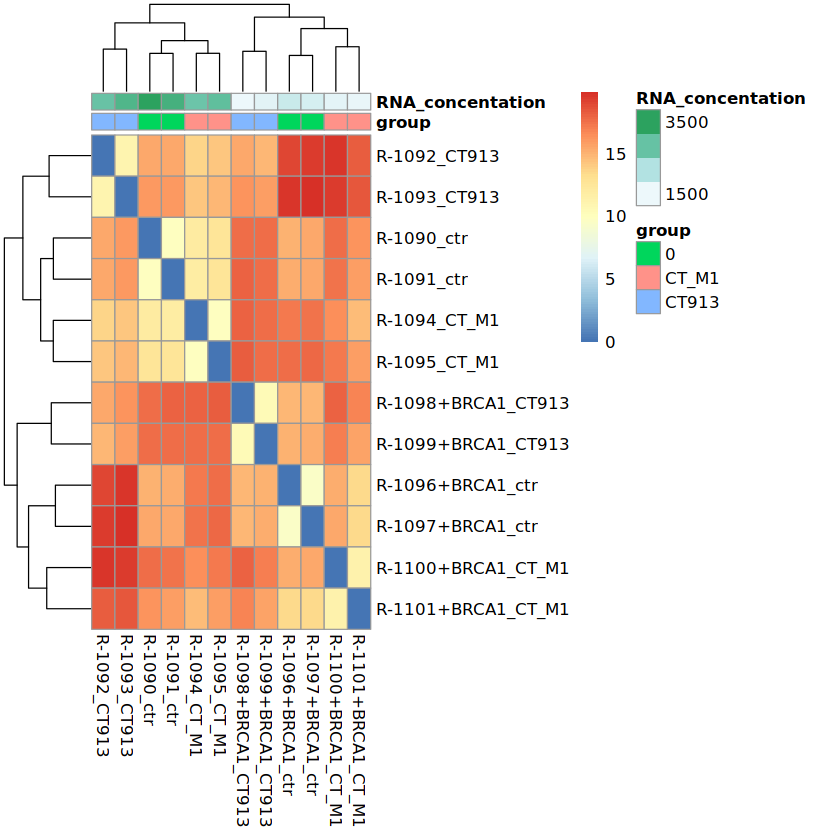

In [48]:
print("sample distance...")
# sample distance rlog TPM:
sampleDists <- dist( t( TPMsRlog ) )
as.matrix( sampleDists )[1:4,1:4]
sampleDistMatrix <- as.matrix( sampleDists )

maxRowWidth <- max(nchar(rownames(sampleDistMatrix)))/3
outf <- paste(outDir,"sampleDist-heatmap.pdf",sep="")
cat("writing",outf,"\n")

maxNameLength <- max(nchar(rownames(sampleDistMatrix)))

ph = pheatmap(mat = sampleDistMatrix, annotation_col = sampleAnnotForPlot)

pdf(width = round(maxNameLength/4)+ncol(sampleDistMatrix)/5 +2,
    height = ncol(sampleDistMatrix)/10+maxNameLength/4 +2,file = outf)
ph
dev.off()

In [49]:
# if labels shall be plotted -> more height necessary:
nameLabelHeight <-  ifelse(nbGenesForClustering<nbGeneNameShowCutoff,nbGenesForClustering/15,0)

###  cluster top varying genes :

[1] "top var genes..."


,R-1090_ctr,R-1091_ctr,R-1092_CT913,R-1093_CT913,R-1094_CT_M1,R-1095_CT_M1,R-1096+BRCA1_ctr,R-1097+BRCA1_ctr,R-1098+BRCA1_CT913,R-1099+BRCA1_CT913,R-1100+BRCA1_CT_M1,R-1101+BRCA1_CT_M1
DDX11L1,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309
WASH7P,1.765705,1.784488,1.810820,1.802271,1.839136,1.775229,1.750889,1.730048,1.750889,1.823249,1.806573,1.939195
MIR1302-10,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309
FAM138A,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309
OR4G4P,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309
OR4G11P,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309,1.107309


DDX11L1       WASH7P   MIR1302-10      FAM138A       OR4G4P      OR4G11P 
2.689299e-32 3.029248e-03 2.689299e-32 2.689299e-32 2.689299e-32 2.689299e-32

[1] 200

writing clustering/geneHeatmap-topVariance-200genes.pdf 


png 
  2

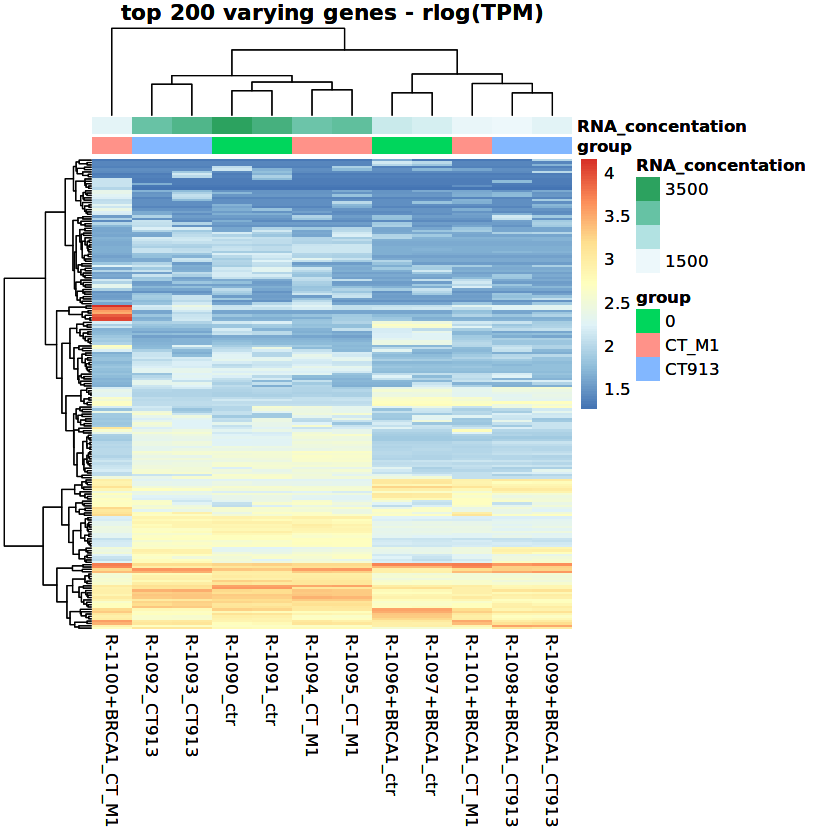

In [50]:
print("top var genes...")
# Heatmap of top varying genes:
# get top n genes with highest variance:
rowVariances <- apply(TPMsRlog,1,var)
head(TPMsRlog)
head(rowVariances)

topVarGenes <- head( order( rowVariances , decreasing=TRUE ), nbGenesForClustering )
length(topVarGenes)
topVarGeneSymbols <- names(rowVariances)[topVarGenes]

outf <- paste(outDir,"geneHeatmap-topVariance-",nbGenesForClustering,"genes.pdf",sep="")
cat("writing",outf,"\n")

ph = pheatmap(mat = TPMsRlog[ topVarGenes, ], main = paste("top",nbGenesForClustering,"varying genes - rlog(TPM)"),
         annotation_col = sampleAnnotForPlot,
         show_rownames = ifelse(nbGenesForClustering<nbGeneNameShowCutoff,T,F))
ph
pdf(width = 4+ncol(TPMsRlog[ topVarGenes, ])/4.5,
    height = 4 + max(100,nrow(TPMsRlog[ topVarGenes, ]))/120 + nameLabelHeight,
     file=outf)
par(oma=c(2,5,2,2))
ph
dev.off()

### cluster by top robust varying genes

In [ ]:
# Heatmap of top varying genes - robust:
#  there may be few genes that are heavily expressed in single patients, which contribute to variance
# more robust variance:
# - sort expression value of each gene
# - remove lowest and highest expr. value, re-calc variance

DDX11L1      WASH7P  MIR1302-10     FAM138A      OR4G4P     OR4G11P 
2.73910e-32 9.18684e-04 2.73910e-32 2.73910e-32 2.73910e-32 2.73910e-32

writing clustering/geneHeatmap-robustVariance-200genes.pdf 


png 
  2

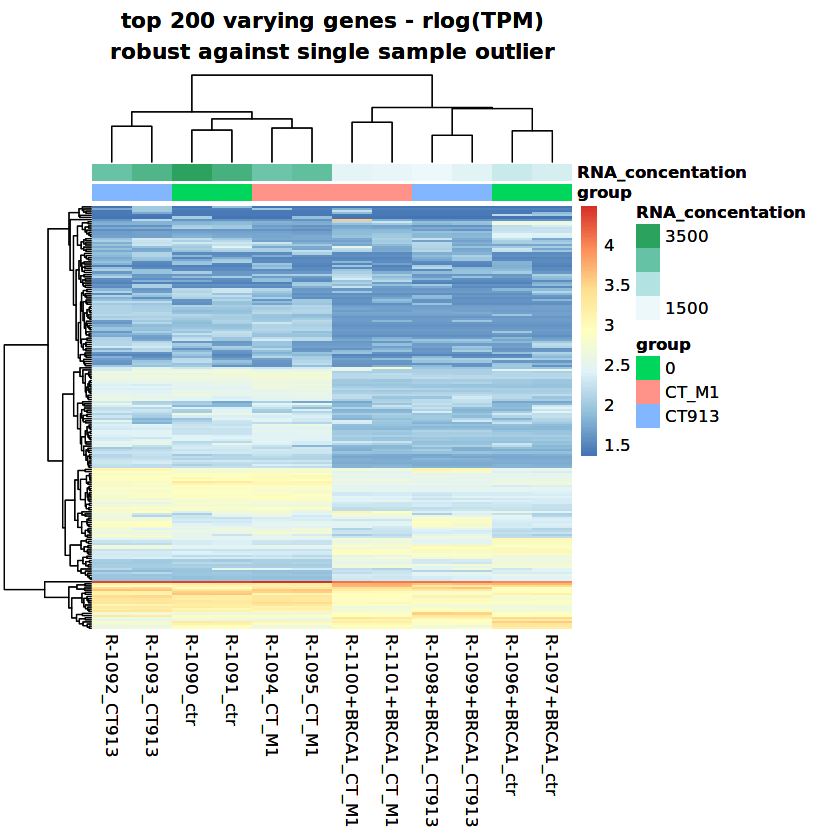

In [51]:
nbSamples <- ncol(TPMsRlog)
robustVariances <- apply(TPMsRlog,1,function(x) var(sort(x)[2:(nbSamples-1)]))
head(robustVariances)
topRobustVarGenes <- head( order( robustVariances , decreasing=TRUE ), nbGenesForClustering )
topRobustVarGeneSymbols <- names(robustVariances)[topRobustVarGenes]

ph = pheatmap(mat = TPMsRlog[ topRobustVarGenes, ], 
          main = paste("top",nbGenesForClustering,"varying genes - rlog(TPM)\nrobust against single sample outlier"),
         annotation_col = sampleAnnotForPlot,
         show_rownames = ifelse(nbGenesForClustering<nbGeneNameShowCutoff,T,F))
ph
                         
outf <- paste(outDir,"geneHeatmap-robustVariance-",nbGenesForClustering,"genes.pdf",sep="")
cat("writing",outf,"\n")

pdf(width = 4+ncol(TPMsRlog[ topRobustVarGenes, ])/4.5,height = 4 + max(100,nrow(TPMsRlog[ topRobustVarGenes, ]))/120 + nameLabelHeight,
   file=outf)
par(oma=c(2,5,2,2))
ph
dev.off()

### top expressed genes:

DDX11L1     WASH7P MIR1302-10    FAM138A     OR4G4P    OR4G11P 
  13.28771   21.57849   13.28771   13.28771   13.28771   13.28771

writing clustering/geneHeatmap-topExpressed-200genes.pdf 


png 
  2

[1] "done"


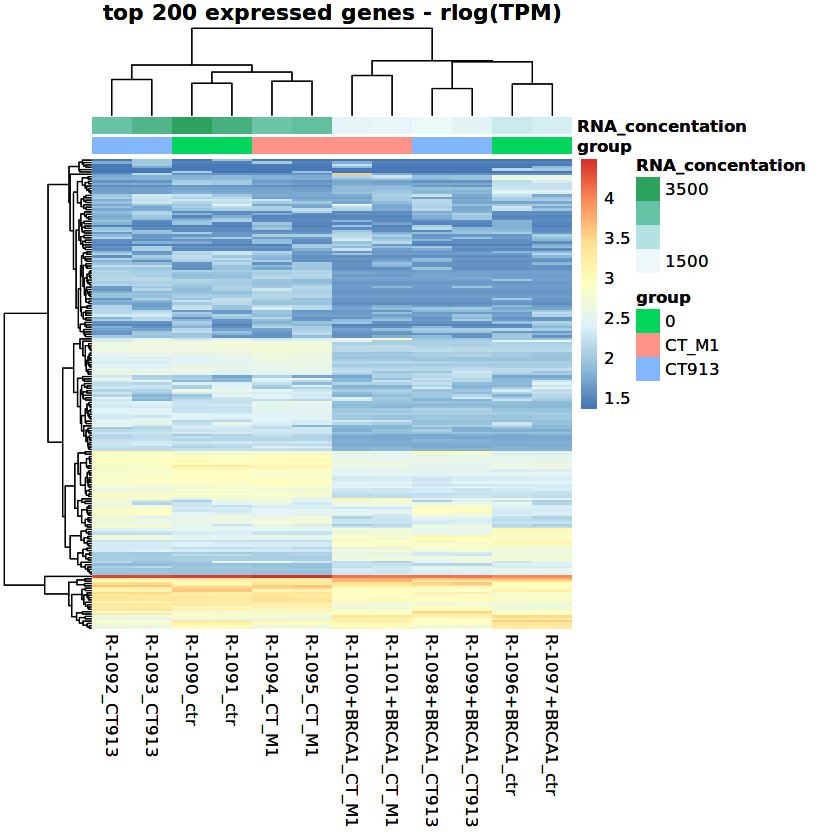

In [52]:
sumExpr <- apply(TPMsRlog,1,function(x) sum(x))
head(sumExpr)
topExprGenes <- head( order( sumExpr , decreasing=TRUE ), nbGenesForClustering )
topExprGeneSymbols <- names(sumExpr)[topExprGenes]

if (haveReducedList) {
colTitle <- paste(nbGenesForClustering,"genes - rlog(TPM)")
outf <- paste(outDir,"geneHeatmap-",nbGenesForClustering,"genes.pdf",sep="")
} else {
colTitle <- paste("top",nbGenesForClustering,"expressed genes - rlog(TPM)")
outf <- paste(outDir,"geneHeatmap-topExpressed-",nbGenesForClustering,"genes.pdf",sep="")
}

ph = pheatmap(mat = TPMsRlog[ topRobustVarGenes, ], 
          main = colTitle, annotation_col = sampleAnnotForPlot,
         show_rownames = ifelse(nbGenesForClustering<nbGeneNameShowCutoff,T,F))
ph
cat("writing",outf,"\n")

pdf(width = 4+ncol(TPMsRlog[ topExprGenes, ])/4.5,
    height = 4 + max(100,nrow(TPMsRlog[ topExprGenes, ]))/120 + nameLabelHeight,
file=outf)
par(oma=c(2,5,2,2))
ph
dev.off()
print("done")